In [159]:
import requests

class PVOutputAPI:
    BASE_URL = "https://pvoutput.org/service/r2/getstatus.jsp"
    
    def __init__(self, api_key, system_id):
        self.api_key = api_key
        self.system_id = system_id

    def get_status(self, date=None, time=None, history=None, ascending=None, limit=None, time_from=None, time_to=None, extended_data=None, another_system_id=None, day_statistics=None):
        params = {
            'd': date,
            't': time,
            'h': history,
            'asc': ascending,
            'limit': limit,
            'from': time_from,
            'to': time_to,
            'ext': extended_data,
            'sid1': another_system_id,
            'stats': day_statistics
        }
        
        headers = {
            'X-Pvoutput-Apikey': self.api_key,
            'X-Pvoutput-SystemId': self.system_id
        }

        response = requests.get(self.BASE_URL, headers=headers, params=params)
        
        if response.status_code == 200:
            return response.text  
        else:
            response.raise_for_status()

# Example usage
if __name__ == "__main__":
    api_key = "a6fde136a0f43555bfe0beff83520a1cb9a49c57"
    system_id = "105034"
    
    pv_output_api = PVOutputAPI(api_key, system_id)
    
    # Example: Get status with specific parameters
    response = pv_output_api.get_status(date="20230531", ascending="1", history="1", time_from="00:00", limit="500", time_to="23:55", extended_data="1", another_system_id="23471")
    print(response)

def parse_response_to_dataframe(response):
    # Split the response string into individual entries
    entries = response.split(';')
    
    # Extract the first 4 fields from each entry
    data = []
    for entry in entries:
        # Skip any empty strings
        fields = entry.split(',')[:5]
        data.append(fields)
    
    # Convert to DataFrame
    df = pd.DataFrame(data, columns=['Date', 'Time', 'Energy generation (kWh)', 'Efficiency', 'Power generation (W)'])
    return df

# Parse the response and convert it to a DataFrame
df = parse_response_to_dataframe(response)
print(df)



20230531,06:05,0,0.000,0,NaN,NaN,NaN,NaN,23.5,223.3,NaN,NaN,NaN,NaN,NaN,NaN;20230531,06:10,3,0.001,36,36,0.012,NaN,NaN,24.0,223.0,NaN,NaN,NaN,NaN,NaN,NaN;20230531,06:15,7,0.002,48,48,0.015,NaN,NaN,25.4,223.1,NaN,NaN,NaN,NaN,NaN,NaN;20230531,06:20,13,0.004,72,72,0.023,NaN,NaN,26.4,223.4,NaN,NaN,NaN,NaN,NaN,NaN;20230531,06:25,19,0.006,72,72,0.023,NaN,NaN,27.0,223.7,NaN,NaN,NaN,NaN,NaN,NaN;20230531,06:30,28,0.009,108,108,0.035,NaN,NaN,27.5,224.2,NaN,NaN,NaN,NaN,NaN,NaN;20230531,06:35,37,0.012,108,108,0.035,NaN,NaN,27.8,223.2,NaN,NaN,NaN,NaN,NaN,NaN;20230531,06:40,49,0.016,144,144,0.046,NaN,NaN,28.1,222.7,NaN,NaN,NaN,NaN,NaN,NaN;20230531,06:45,62,0.020,156,156,0.050,NaN,NaN,28.4,223.3,NaN,NaN,NaN,NaN,NaN,NaN;20230531,06:50,78,0.025,192,192,0.062,NaN,NaN,28.5,223.8,NaN,NaN,NaN,NaN,NaN,NaN;20230531,06:55,94,0.030,192,192,0.062,NaN,NaN,28.8,223.5,NaN,NaN,NaN,NaN,NaN,NaN;20230531,07:00,114,0.037,240,240,0.077,NaN,NaN,29.0,223.4,NaN,NaN,NaN,NaN,NaN,NaN;20230531,07:05,136,0.044,264,264,0.085,NaN

In [160]:
# Combine Date and Time into a single DateTime column
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Set DateTime as the index
df.set_index('DateTime', inplace=True)

# Create a complete time range for the day at 5-minute intervals
full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')

# Create a complete DataFrame with zero values
full_day_df = pd.DataFrame(index=full_day)
full_day_df['Energy generation (kWh)'] = 0
full_day_df['Efficiency'] = 0.000
full_day_df['Power generation (W)'] = 0

# Merge the complete DataFrame with the existing data
merged_df = full_day_df.merge(df, how='left', left_index=True, right_index=True, suffixes=('', '_y'))

# Fill missing values with zero
merged_df['Energy generation (kWh)'] = merged_df['Energy generation (kWh)_y'].fillna(0)
merged_df['Efficiency'] = merged_df['Efficiency_y'].fillna(0.000)
merged_df['Power generation (W)'] = merged_df['Power generation (W)_y'].fillna(0)

# Drop the duplicate columns
merged_df = merged_df[['Energy generation (kWh)', 'Efficiency', 'Power generation (W)']]

# Filter out rows that are not exact hour values
merged_df = merged_df[merged_df.index.minute == 0]


# Reset index to have DateTime as a column
merged_df.reset_index(inplace=True)


In [164]:

values = merged_df['Energy generation (kWh)'].tolist()


                 index Energy generation (kWh) Efficiency Power generation (W)
0  2023-05-31 00:00:00                       0        0.0                    0
1  2023-05-31 01:00:00                       0        0.0                    0
2  2023-05-31 02:00:00                       0        0.0                    0
3  2023-05-31 03:00:00                       0        0.0                    0
4  2023-05-31 04:00:00                       0        0.0                    0
5  2023-05-31 05:00:00                       0        0.0                    0
6  2023-05-31 06:00:00                       0        0.0                    0
7  2023-05-31 07:00:00                     114      0.037                  240
8  2023-05-31 08:00:00                     532      0.171                  588
9  2023-05-31 09:00:00                    1338      0.429                 1320
10 2023-05-31 10:00:00                    3104      0.995                 1992
11 2023-05-31 11:00:00                    5240      

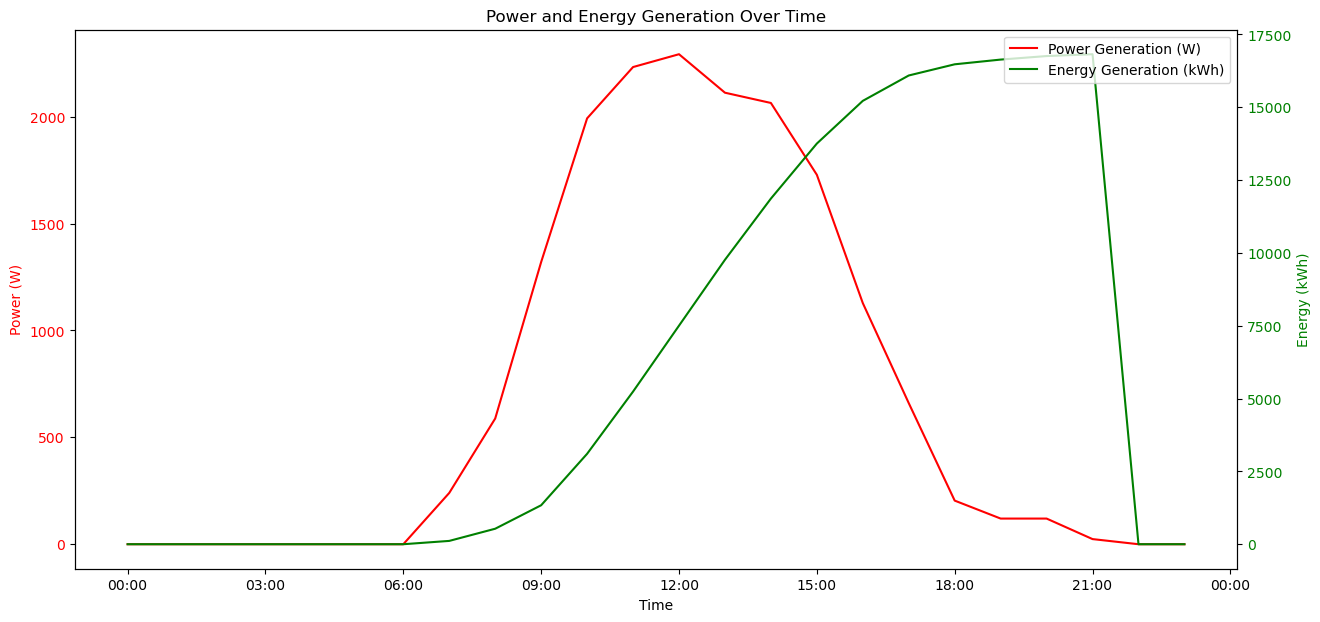

In [162]:
df = merged_df.copy()
# Convert 'index' column to datetime
df['index'] = pd.to_datetime(df['index'])

# Plotting
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot Power Generation
ax1.plot(df['index'], df['Power generation (W)'], 'r-', label='Power Generation (W)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Power (W)', color='r')
ax1.tick_params(axis='y', labelcolor='r')
#ax1.set_ylim(0, 5000)  # Scale y-axis to 5000W

# Create a secondary y-axis for Energy Generation
ax2 = ax1.twinx()
ax2.plot(df['index'], df['Energy generation (kWh)'], 'g-', label='Energy Generation (kWh)')
ax2.set_ylabel('Energy (kWh)', color='g')
ax2.tick_params(axis='y', labelcolor='g')
#ax2.set_ylim(0, 20)  # Scale y-axis to 20 kWh

# Adding a legend
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

# Formatting the x-axis to show time only
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))

# Adding a title
plt.title('Power and Energy Generation Over Time')

# Display the plot
plt.show()

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta

class PVOutputAPI:
    BASE_URL = "https://pvoutput.org/service/r2/getstatus.jsp"
    
    def __init__(self, api_key, system_id):
        self.api_key = api_key
        self.system_id = system_id

    def get_status(self, date=None, time=None, history=None, ascending=None, limit=None, time_from=None, time_to=None, extended_data=None, another_system_id=None, day_statistics=None):
        params = {
            'd': date,
            't': time,
            'h': history,
            'asc': ascending,
            'limit': limit,
            'from': time_from,
            'to': time_to,
            'ext': extended_data,
            'sid1': another_system_id,
            'stats': day_statistics
        }
        
        headers = {
            'X-Pvoutput-Apikey': self.api_key,
            'X-Pvoutput-SystemId': self.system_id
        }

        response = requests.get(self.BASE_URL, headers=headers, params=params)
        
        if response.status_code == 200:
            return response.text
        else:
            response.raise_for_status()

def parse_response_to_dataframe(response):
    entries = response.split(';')
    data = []
    for entry in entries:
        fields = entry.split(',')[:5]
        data.append(fields)
    
    df = pd.DataFrame(data, columns=['Date', 'Time', 'Energy generation (kWh)', 'Efficiency', 'Power generation (W)'])
    return df

def process_data_for_date(api, date):
    response = api.get_status(date=date, ascending="1", history="1", time_from="00:00", limit="500", time_to="23:55", extended_data="1", another_system_id="23471")
    df = parse_response_to_dataframe(response)
    
    df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    df.set_index('DateTime', inplace=True)
    
    full_day = pd.date_range(start=df['Date'].iloc[0] + ' 00:00', end=df['Date'].iloc[0] + ' 23:55', freq='5T')
    full_day_df = pd.DataFrame(index=full_day)
    full_day_df['Energy generation (kWh)'] = 0
    full_day_df['Efficiency'] = 0.000
    full_day_df['Power generation (W)'] = 0
    
    merged_df = full_day_df.merge(df, how='left', left_index=True, right_index=True, suffixes=('', '_y'))
    
    merged_df['Energy generation (kWh)'] = merged_df['Energy generation (kWh)_y'].fillna(0)
    merged_df['Efficiency'] = merged_df['Efficiency_y'].fillna(0.000)
    merged_df['Power generation (W)'] = merged_df['Power generation (W)_y'].fillna(0)
    
    merged_df = merged_df[['Energy generation (kWh)', 'Efficiency', 'Power generation (W)']]
    merged_df = merged_df[merged_df.index.minute == 0]
    merged_df.reset_index(inplace=True)
    
    return merged_df

def main():
    api_key = "a6fde136a0f43555bfe0beff83520a1cb9a49c57"
    system_id = "105034"
    pv_output_api = PVOutputAPI(api_key, system_id)
    
    all_data = []
    start_date = datetime(2023, 1, 1)
    end_date = datetime(2023, 12, 31)
    current_date = start_date
    
    while current_date <= end_date:
        date_str = current_date.strftime("%Y%m%d")
        try:
            daily_data = process_data_for_date(pv_output_api, date_str)
            values = daily_data['Energy generation (kWh)'].tolist()
            all_data.append({'Date': date_str, 'Values': values})
        except Exception as e:
            print(f"Error processing date {date_str}: {e}")
        current_date += timedelta(days=1)
    
    final_df = pd.DataFrame(all_data)
    print(final_df)

if __name__ == "__main__":
    main()
